# Poor Confidence Analysis
This analysis aims to improve the NER model by studying the predictions done by the model. This is done firstly by identifying the weakness or limitations discovered from the prediction results. So, by looking at the outputs, the confidence score can be the area of focus for this analysis.

The idea of this analysis is to find out if the low confidence scores are justifiable. For example, is the confidence score related to the volume of the dataset, frequency of the labels, or word rarity? This analysis covers the:
1. label frequency
2. text frequency
3. confidence score distribution
4. text length
5. text complexity
6. context

This can be determined by answering these questions:
1. Is there a correlation between label frequency and confidence scores?    (`label`)
2. Are low-confidence predictions associated with text frequency/rarity?    (`text`)
3. Do certain label types show systematic confidence patterns?              (`label`)
4. Is confidence score correlated with text length?                         (`text`)
5. Is confidence score correlated with complexity?                          (`text`)
6. Does context window size affect confidence?

Based on these questions, 

* If low scores correlate with rare labels: Augment training data for underrepresented classes.
* If low scores correlate with rare words: Add domain-specific vocabulary for training.
* If low scores are consistent with certain label group: Focused annotation to cator specific labelings.
* If low scores are consistent with longer texts: Review span detection. (KIV)
* If low scores cluster in specific positions: Review context window. (KIV)

If all are unclear: Review model architecture or hyperparameter tuning

-------------
------
## Data Pre-processing

#### Import Libraries

In [829]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats             # correlation

#### Load Dataset

In [830]:
# load csv
df = pd.read_csv('results_main.csv')
df.head()

,start,end,text,label,score
0,11,33,ashraf semakin misteri,PERSON,0.624216
1,36,51,utusan malaysia,ORG,0.669583
2,63,75,waris lelaki,PERSON,0.617030
3,96,111,utusan malaysia,ORG,0.778188
4,112,130,abang jo tak tamak,PERSON,0.896389


In [831]:
df.info

<bound method DataFrame.info of          start      end                    text     label     score
0           11       33  ashraf semakin misteri    PERSON  0.624216
1           36       51         utusan malaysia       ORG  0.669583
2           63       75            waris lelaki    PERSON  0.617030
3           96      111         utusan malaysia       ORG  0.778188
4          112      130      abang jo tak tamak    PERSON  0.896389
...        ...      ...                     ...       ...       ...
21703  1296557  1296571          berpuluh-puluh  QUANTITY  0.605398
21704  1296585  1296590                   gempa     EVENT  0.639610
21705  1296615  1296621                  bandar       LOC  0.572937
21706  1296631  1296639                istanbul       LOC  0.941040
21707  1296671  1296676                   izmir       LOC  0.973139

[21708 rows x 5 columns]>

In [832]:
# normalize text
df['text'] = df['text'].str.lower()
df.head()

,start,end,text,label,score
0,11,33,ashraf semakin misteri,PERSON,0.624216
1,36,51,utusan malaysia,ORG,0.669583
2,63,75,waris lelaki,PERSON,0.617030
3,96,111,utusan malaysia,ORG,0.778188
4,112,130,abang jo tak tamak,PERSON,0.896389


In [833]:
# duplicates
df.drop_duplicates().head()

,start,end,text,label,score
0,11,33,ashraf semakin misteri,PERSON,0.624216
1,36,51,utusan malaysia,ORG,0.669583
2,63,75,waris lelaki,PERSON,0.617030
3,96,111,utusan malaysia,ORG,0.778188
4,112,130,abang jo tak tamak,PERSON,0.896389


-------------
--------
## Exploratory Data Analysis
This part aims to explore the dataset in hopes to uncover hidden perspectives.

#### Label Distribution

In [834]:
df.head()

,start,end,text,label,score
0,11,33,ashraf semakin misteri,PERSON,0.624216
1,36,51,utusan malaysia,ORG,0.669583
2,63,75,waris lelaki,PERSON,0.617030
3,96,111,utusan malaysia,ORG,0.778188
4,112,130,abang jo tak tamak,PERSON,0.896389


In [835]:
# label distribution
df['label'].value_counts()

label
ORG            5321
PERSON         4906
LOC            4704
EVENT          1506
GPE            1089
PRODUCT        1030
TIME            982
MONEY           628
QUANTITY        479
LAW             386
WORK_OF_ART     231
PERCENT         184
CARDINAL        124
NORP             76
FAC              60
ORDINAL           2
Name: count, dtype: int64

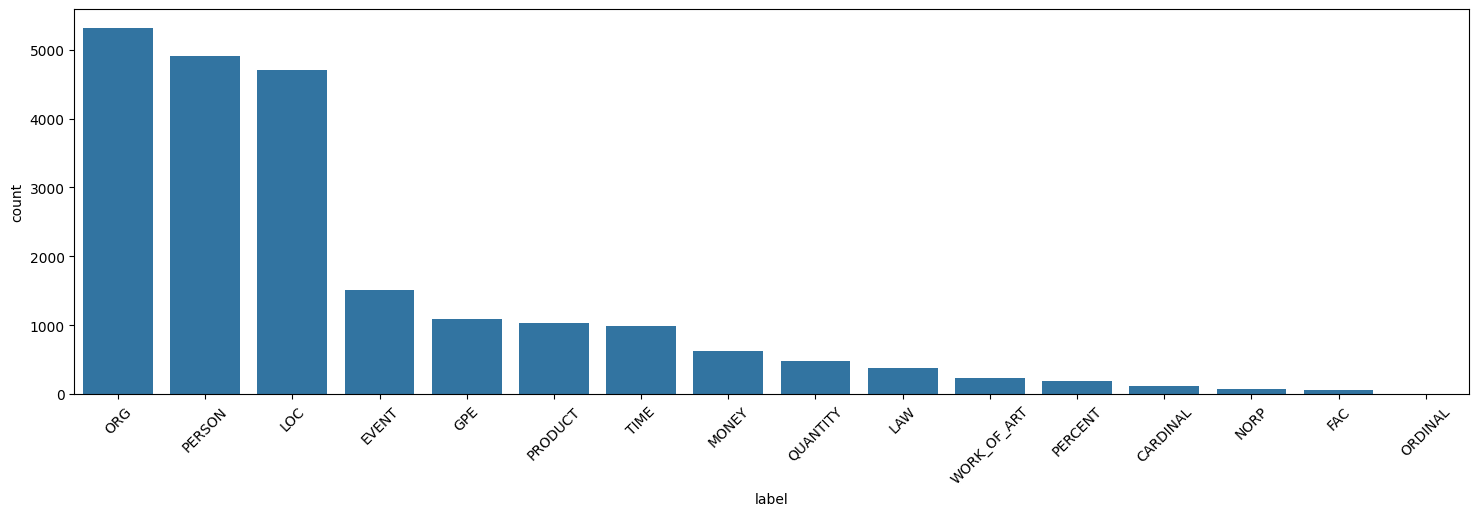

In [836]:
# visualize
label_freq = df['label'].value_counts().index

plt.figure(figsize=(18,5))
sns.countplot(x=df['label'],data=df, order=label_freq)
plt.xticks(rotation=45)
plt.show()

From this graph, it is safe to assume that the high-frequency labels are the 3 highest, while the others are teh low-frequency labels. This is because the gap between the third and the fourth highest is relatively big (1500 vs 500), when compared to other inter-label gaps.

#### High and Low Frequency Labels

In [837]:
# overview
df.head()

,start,end,text,label,score
0,11,33,ashraf semakin misteri,PERSON,0.624216
1,36,51,utusan malaysia,ORG,0.669583
2,63,75,waris lelaki,PERSON,0.617030
3,96,111,utusan malaysia,ORG,0.778188
4,112,130,abang jo tak tamak,PERSON,0.896389


In [838]:
# drop columns
freq = df.drop(['start','end','text'], axis=1)
freq.head()

,label,score
0,PERSON,0.624216
1,ORG,0.669583
2,PERSON,0.617030
3,ORG,0.778188
4,PERSON,0.896389


In [839]:
# list labels
freq['label'].unique()

array(['PERSON', 'ORG', 'LOC', 'PRODUCT', 'PERCENT', 'WORK_OF_ART', 'GPE',
       'TIME', 'MONEY', 'EVENT', 'QUANTITY', 'LAW', 'CARDINAL', 'NORP',
       'FAC', 'ORDINAL'], dtype=object)

In [840]:
# split into higher and lower frequency groups
high_freq_label = ['PERSON','ORG','LOC']
low_freq_label = ['PRODUCT', 'QUANTITY', 'EVENT', 'GPE',
       'CARDINAL', 'TIME', 'LAW', 'MONEY', 'PERCENT', 'WORK_OF_ART',
       'NORP', 'FAC', 'ORDINAL']

freq_high = freq[freq['label'].isin(high_freq_label)]
freq_low = freq[freq['label'].isin(low_freq_label)]

#### Confidence Score Disctribution

In [841]:
# get mean confidence score
conf = df.groupby('label')['score'].mean().reset_index()
conf = conf.sort_values('score', ascending=False)

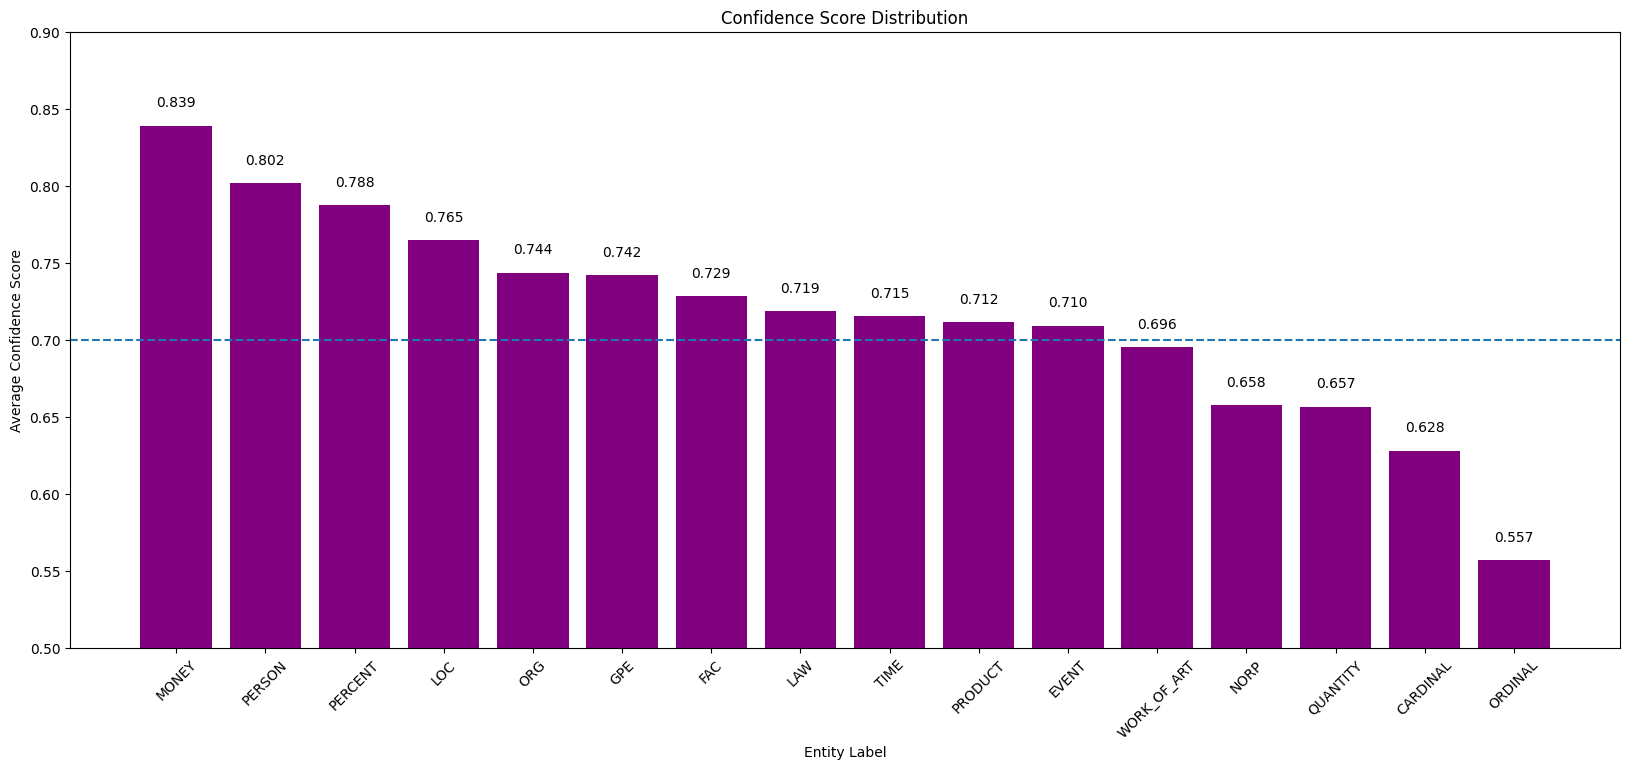

In [842]:
# visualize
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 1, 1) 
bars = ax.bar(conf['label'], conf['score'], color='purple')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2,
            height + 0.01, f'{height:.3f}',
            ha='center', va='bottom', fontsize=10)

ax.set_title('Confidence Score Distribution')
ax.set_xlabel('Entity Label')
ax.set_ylabel('Average Confidence Score')
ax.set_ylim(0.5, 0.9)
ax.axhline(y=0.7,linestyle='--')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()


Based on this distribution, there are 5 labels that are considered to be low-confidence.

#### Confidence Scores in High and Low Frequency Labels

In [843]:
# get mean score
label_score_mean_high = freq_high.groupby('label')['score'].mean().reset_index()
label_score_mean_low = freq_low.groupby('label')['score'].mean().reset_index()

In [844]:
# sort mean score
label_score_mean_high = label_score_mean_high.sort_values('score', ascending=False)
label_score_mean_low = label_score_mean_low.sort_values('score', ascending=False)

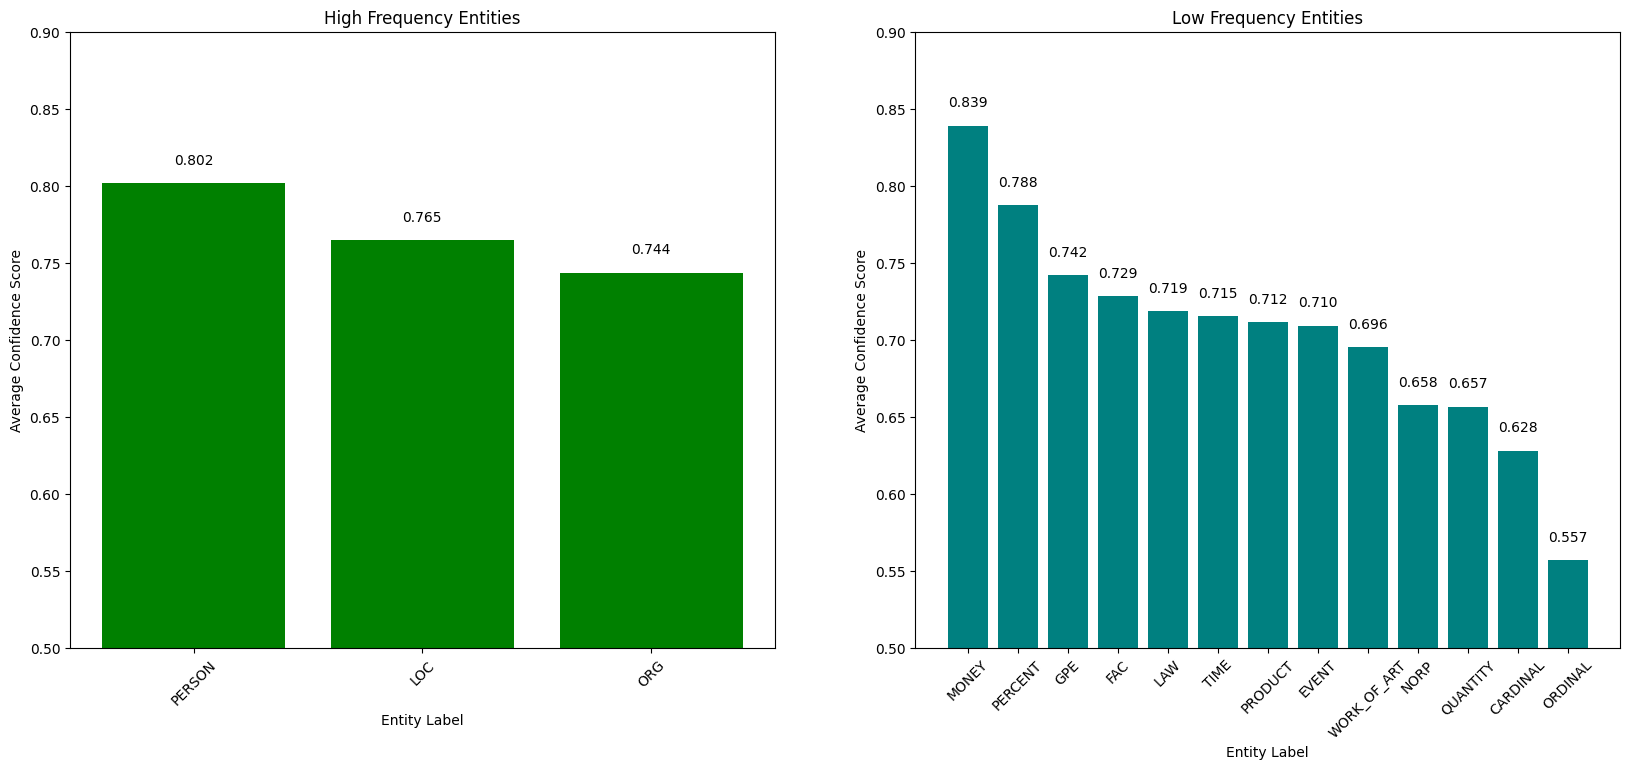

In [845]:
# visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# high frequency labels
bars1 = ax1.bar(label_score_mean_high['label'], 
               label_score_mean_high['score'],
               color='green')

# labeling
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# setting
ax1.set_title('High Frequency Entities')
ax1.set_xlabel('Entity Label')
ax1.set_ylabel('Average Confidence Score')
ax1.set_ylim(0.5, 0.9)
ax1.tick_params(axis='x', rotation=45)

# low frequency labels
bars2 = ax2.bar(label_score_mean_low['label'], 
               label_score_mean_low['score'],
               color='teal')

# labeling
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# setting
ax2.set_title('Low Frequency Entities')
ax2.set_xlabel('Entity Label')
ax2.set_ylabel('Average Confidence Score')
ax2.set_ylim(0.5, 0.9)
ax2.tick_params(axis='x', rotation=45)

# display
plt.tight_layout
plt.show()

Based on these graphs, the lowest confidence score for the high-frequency labels is around 76%, while the highest confidence score for the low-frequency labels is around 82%. This means that even if the label is relatively rare, the confidence score can still be high. Even so, it cannot be a certain that there is no correlation between the label rarity and the confidence score. Therefore, a correlation analysis can be done to further confirm this.

#### Low Rarity Texts

In [846]:
# overview
df.head()

,start,end,text,label,score
0,11,33,ashraf semakin misteri,PERSON,0.624216
1,36,51,utusan malaysia,ORG,0.669583
2,63,75,waris lelaki,PERSON,0.617030
3,96,111,utusan malaysia,ORG,0.778188
4,112,130,abang jo tak tamak,PERSON,0.896389


In [847]:
# text frequency
text_freq = df['text'].value_counts().reset_index() 
text_freq

,text,count
0,utusan malaysia,542
1,kuala lumpur,343
2,malaysia,339
3,polis,168
4,petaling jaya,126
...,...,...
8652,nur diana petra,1
8653,datuk seri raja shah zurin raja aman shah,1
8654,tengku muhammad fakhry petra,1
8655,ipk kelantan kira-kira pukul 4 petang diiringi...,1


In [848]:
# texts that appeared only once
text_low = text_freq[text_freq['count'] == 1]
text_low

,text,count
2955,negara asal,1
2956,rm157 juta,1
2957,dr. ismuni bohari,1
2958,akta hasutan,1
2959,penggiat seni,1
...,...,...
8652,nur diana petra,1
8653,datuk seri raja shah zurin raja aman shah,1
8654,tengku muhammad fakhry petra,1
8655,ipk kelantan kira-kira pukul 4 petang diiringi...,1


From this, there are about 4000 texts that appeared only once. That's more than half of the whole dataset (6000 texts)! This is also while excluding the texts that appeared only twice or thrice.

However, this is to be expected since texts with unique nomenclature or numbers might be a factor to this phenomenon. 

#### Distribution of Confidence Score in Low Rarity Texts

In [849]:
# overview
df.head()

,start,end,text,label,score
0,11,33,ashraf semakin misteri,PERSON,0.624216
1,36,51,utusan malaysia,ORG,0.669583
2,63,75,waris lelaki,PERSON,0.617030
3,96,111,utusan malaysia,ORG,0.778188
4,112,130,abang jo tak tamak,PERSON,0.896389


In [850]:
# get score for low rarity texts
text_conf = df.groupby('text')['score'].mean().reset_index()  # get mean confidence score

text_low_conf = pd.merge(text_freq, text_conf, on='text')
text_low_conf = text_low_conf[text_low_conf['count'] == 1]
text_low_conf.sort_values('score',ascending=False)

,text,count,score
2976,harvey elliott,1,0.995564
3206,novak djokovic,1,0.995105
3838,harry maguire,1,0.994720
3133,mimi fly,1,0.994010
3863,muhammad yunus,1,0.993510
...,...,...,...
4931,kejohanan sukan sea,1,0.500327
7552,calon mentua,1,0.500295
4921,kampung glam,1,0.500206
6345,bekalan makanan,1,0.500189


Here, we can see that the rare texts has the confidence score at both high and low ends.

In [851]:
score_low = df[df['score'] < 0.7]
score_low.sort_values('score',ascending=False)

,start,end,text,label,score
9762,528509,528516,kemboja,GPE,0.699989
7445,314302,314314,pelitup muka,PRODUCT,0.699989
3450,66285,66288,ceo,PERSON,0.699948
5912,189700,189709,pertemuan,EVENT,0.699943
1330,26670,26685,utusan malaysia,ORG,0.699939
...,...,...,...,...,...
17776,1154306,1154312,gambar,WORK_OF_ART,0.500136
2330,46094,46099,kubur,ORG,0.500109
16347,1078109,1078116,majikan,ORG,0.500095
8401,398643,398647,ajaz,PERSON,0.500067


There are about 5000 texts that has low confidence scores.

#### Distribution of Text Lengths

In [852]:
txt_len = df.copy()
txt_len['chara'] = df['text'].str.len()
txt_len

,start,end,text,label,score,chara
0,11,33,ashraf semakin misteri,PERSON,0.624216,22
1,36,51,utusan malaysia,ORG,0.669583,15
2,63,75,waris lelaki,PERSON,0.617030,12
3,96,111,utusan malaysia,ORG,0.778188,15
4,112,130,abang jo tak tamak,PERSON,0.896389,18
...,...,...,...,...,...,...
21703,1296557,1296571,berpuluh-puluh,QUANTITY,0.605398,14
21704,1296585,1296590,gempa,EVENT,0.639610,5
21705,1296615,1296621,bandar,LOC,0.572937,6
21706,1296631,1296639,istanbul,LOC,0.941040,8


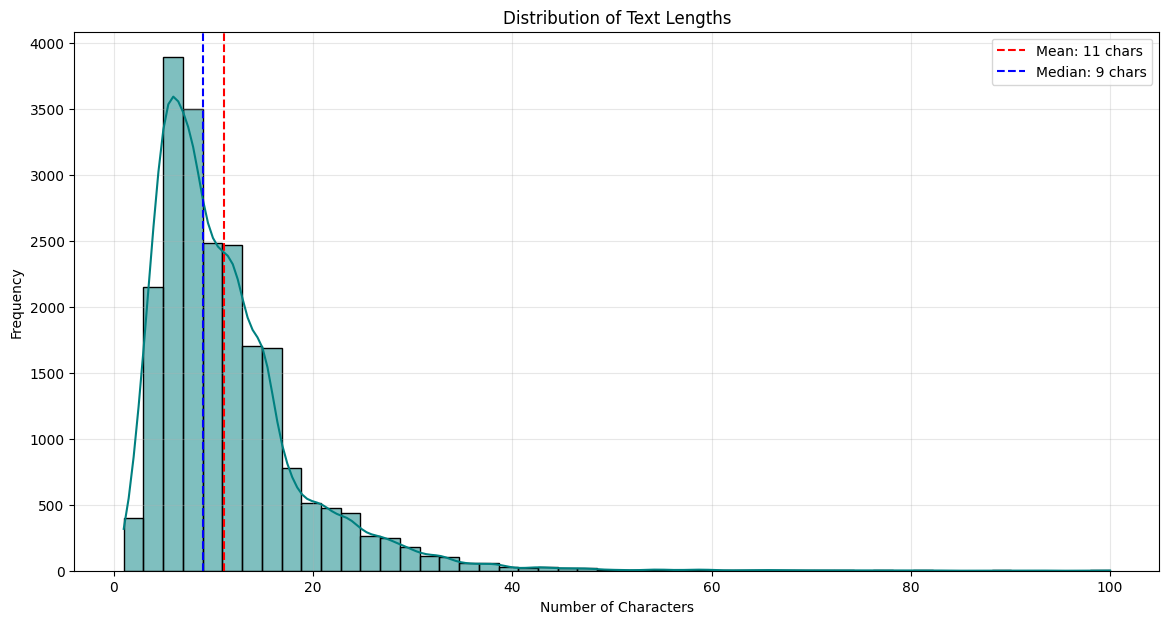

In [853]:
# distribution of text length
plt.figure(figsize=(14, 7))

# histogram
sns.histplot(txt_len['chara'], bins=50, kde=True, color='teal')

# mean line
mean_length = txt_len['chara'].mean()
plt.axvline(mean_length, color='red', linestyle='--', 
            label=f'Mean: {mean_length:.0f} chars')

# median line
median_length = txt_len['chara'].median()
plt.axvline(median_length, color='blue', linestyle='--', 
            label=f'Median: {median_length:.0f} chars')

# plot
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)

plt.show()

This distribution histogram is right-skewed. It comprises of mostly short texts.

--------------
--------------
## Data Analysis

-------------
### Q1: Is there a correlation between label frequency and confidence scores?
Study on the mean confidence scores and label frequency correlation. This is to see if high frequency means high confidence score, or vice versa.

#### Data Preparation

In [854]:
# overview
df.head()

,start,end,text,label,score
0,11,33,ashraf semakin misteri,PERSON,0.624216
1,36,51,utusan malaysia,ORG,0.669583
2,63,75,waris lelaki,PERSON,0.617030
3,96,111,utusan malaysia,ORG,0.778188
4,112,130,abang jo tak tamak,PERSON,0.896389


In [855]:
# create new dataset
q1_label = df['label'].value_counts().reset_index()         # get label frequency
q1_conf = df.groupby('label')['score'].mean().reset_index() # get mean confidence score

q1_label_analysis = pd.merge(q1_label, q1_conf, on='label')
q1_label_analysis.sort_values('score',ascending=False)

,label,count,score
7,MONEY,628,0.839269
1,PERSON,4906,0.801885
11,PERCENT,184,0.787938
2,LOC,4704,0.764881
0,ORG,5321,0.743870
4,GPE,1089,0.742014
14,FAC,60,0.728653
9,LAW,386,0.718744
6,TIME,982,0.715400
5,PRODUCT,1030,0.711823


#### Correlation Analysis
In this analysis, the tests that will be conducted are:
1. Pearson correlation - to determine the linear relationship
2. Spearman correlation - to determine the monotonic relationship
3. Shapiro-Wilk test - to determine if its normally distributed

**Null hypothesis:**\
There is no correlation between label frequency and confidence scores.

**Alternative hypothesis:**\
There is a correlation between label frequency and confidence scores.

In [856]:
# pearson
q1_pearson_corr, q1_p_value = stats.pearsonr(
    q1_label_analysis['count'],
    q1_label_analysis['score']
)

# spearman
q1_spearman_rho, q1_p_spearman = stats.spearmanr(
    q1_label_analysis['count'],
    q1_label_analysis['score']
)

# normality test
q1_shapiro_test = stats.shapiro(q1_label_analysis['score'])

In [857]:
print(f"Spearman rho    : {q1_spearman_rho:.3f}")
print(f"Spearman p      : {q1_p_spearman:.4f}\n")
print(f"Pearson r       : {q1_pearson_corr:.3f}")
print(f"Pearson p       : {q1_p_value:.4f}\n")
print(f"Shapiro-Wilk W  : {q1_shapiro_test[0]:.3f}")
print(f"Shapiro-Wilk p  : {q1_shapiro_test[1]:.4f}\n")

Spearman rho    : 0.535
Spearman p      : 0.0326

Pearson r       : 0.443
Pearson p       : 0.0859

Shapiro-Wilk W  : 0.974
Shapiro-Wilk p  : 0.8984



Based on these results:
* There is a significant (p < 0.05) strong positive monotonic relationship (rho > 0.6). This means that as label frequency increases, confidence scores consistently increase, but not necessarily in a straight-line pattern - Spearman correlation test
* There is a significant (p < 0.05) moderate positive linear relationship (r > 0.4, r < 0.6). This means that higher frequency moderately predicts higher confidence in a linear pattern. - Pearson correlation test
* Since the rho > r, the monotonic relationship is stronger than the linear relationship. This means that even though higher frequency boosts the confidence score, the boost will decrease with higher frequency.
* Since both of these tests are significant, the results are not random.
* The data is normally distributed (p > 0.05). - Shapiro-Wilk test

Therefore, we reject the null hypothesis.

For fine-tuning, training data that focuses on the low-frequency labels can be used for augmentation.

In [ ]:
# filter low-frequency labels in main dataset
ft_q1 = df[df['label'].isin(low_freq_label)]
ft_q1 = ft_q1[ft_q1['score'] < 0.7]
ft_q1.sort_values('score')

,start,end,text,label,score
17776,1154306,1154312,gambar,WORK_OF_ART,0.500136
1245,24912,24927,bekalan makanan,PRODUCT,0.500189
4409,82087,82091,maut,EVENT,0.500217
4445,82577,82581,maut,EVENT,0.500217
14253,904389,904408,kejohanan sukan sea,EVENT,0.500327
...,...,...,...,...,...
15829,1033687,1033697,rm210 juta,MONEY,0.699715
7010,285396,285416,separuh masa pertama,TIME,0.699883
5912,189700,189709,pertemuan,EVENT,0.699943
7445,314302,314314,pelitup muka,PRODUCT,0.699989


------------
### Q2: Are low-confidence predictions correlated with text frequency/rarity?
Study on the low confidence scores and text frequency. This is to see if lower rarity means lower confidence score, or vice versa.

#### Data Preparation

In [859]:
# overview
df.head()

,start,end,text,label,score
0,11,33,ashraf semakin misteri,PERSON,0.624216
1,36,51,utusan malaysia,ORG,0.669583
2,63,75,waris lelaki,PERSON,0.617030
3,96,111,utusan malaysia,ORG,0.778188
4,112,130,abang jo tak tamak,PERSON,0.896389


In [860]:
# create new dataset
q2_text = df['text'].value_counts().reset_index()           # get text frequency
q2_conf = df.groupby('text')['score'].mean().reset_index()  # get mean confidence score

q2_text_analysis = pd.merge(q2_text, q2_conf, on='text')
q2_text_analysis

,text,count,score
0,utusan malaysia,542,0.712535
1,kuala lumpur,343,0.866508
2,malaysia,339,0.733004
3,polis,168,0.782803
4,petaling jaya,126,0.756735
...,...,...,...
8652,nur diana petra,1,0.772561
8653,datuk seri raja shah zurin raja aman shah,1,0.670892
8654,tengku muhammad fakhry petra,1,0.834899
8655,ipk kelantan kira-kira pukul 4 petang diiringi...,1,0.598035


#### Correlation Analysis
In this analysis, the tests that will be conducted are:
1. Pearson correlation - to determine the linear relationship
2. Spearman correlation - to determine the monotonic relationship

**Null hypothesis:**\
There is no correlation between text frequency and confidence scores.

**Alternative hypothesis:**\
There is a correlation between text frequency and confidence scores.

In [861]:
# pearson
q2_pearson_corr, q2_p_value = stats.pearsonr(
    q2_text_analysis['count'],
    q2_text_analysis['score']
)

# spearman
q2_spearman_rho, q2_p_spearman = stats.spearmanr(
    q2_text_analysis['count'],
    q2_text_analysis['score']
)

In [862]:
print(f"Spearman rho: {q2_spearman_rho:.3f}")
print(f"Spearman p: {q2_p_spearman:.4f}\n")
print(f"Pearson r: {q2_pearson_corr:.3f}")
print(f"Pearson p: {q2_p_value:.4f}\n")

Spearman rho: 0.031
Spearman p: 0.0039

Pearson r: 0.009
Pearson p: 0.3969



Based on these results:
* There is a significant (p < 0.05) but negligible monotonic relationship (rho < 0.1). This means that there is no meaningful relationship between text and confidence score. - Spearman correlation test
* There is no significant (p > 0.05) linear relationship (r < 0.1). This means that there is no evidence of linear relationship between text and confidence score. - Pearson correlation test

Therefore, we do not reject the null hypothesis.

The fine-tuning should be aimed at other factors instead.

This further justifies the EDA,  where the confidence scores are covered from both high and low ends from the texts, despite the rarity of the texts.

------------
### Q3: Do certain label types show systematic confidence patterns?
Analyze low confidence score distributions per label type. This is to see whether certain labels are under-trained.

#### Data Preparation

In [863]:
# overview
df.head()

,start,end,text,label,score
0,11,33,ashraf semakin misteri,PERSON,0.624216
1,36,51,utusan malaysia,ORG,0.669583
2,63,75,waris lelaki,PERSON,0.617030
3,96,111,utusan malaysia,ORG,0.778188
4,112,130,abang jo tak tamak,PERSON,0.896389


In [864]:
# sort and filter score < 0.7
q3 = df.sort_values('score', ascending=False)
q3 = q3[q3['score'] < 0.7]
q3

,start,end,text,label,score
9762,528509,528516,kemboja,GPE,0.699989
7445,314302,314314,pelitup muka,PRODUCT,0.699989
3450,66285,66288,ceo,PERSON,0.699948
5912,189700,189709,pertemuan,EVENT,0.699943
1330,26670,26685,utusan malaysia,ORG,0.699939
...,...,...,...,...,...
17776,1154306,1154312,gambar,WORK_OF_ART,0.500136
2330,46094,46099,kubur,ORG,0.500109
16347,1078109,1078116,majikan,ORG,0.500095
8401,398643,398647,ajaz,PERSON,0.500067


In [865]:
# number of labels
print(f"number of labels with low-scores    : {len(q3['label'].unique())}")
print(f"number of labels on main            : {len(df['label'].unique())}")

number of labels with low-scores    : 16
number of labels on main            : 16


It seems that there are low-confidence scores for all  types of lables. However, based on our EDA, the lables that has low-average confidence scores are the FAC, NORP, QUANTITY, CARDINAL, and ORDINAL (5 labels). This might be because of outliers in each label type. But to be sure, the weight of the low confidence scores and high confidence scores can be measured for each label. Since the number of the scores cannot be compared because of relative frequencies, percentages can be used for the comparison. 

#### Compare Confidence Score of Individual Labels
Get horizontal bar chart for each label (16 bar charts), with confidence score of 0.7 as the sperator for each chart.

In [866]:
# get back full dataset
q3 = df
q3.head()

,start,end,text,label,score
0,11,33,ashraf semakin misteri,PERSON,0.624216
1,36,51,utusan malaysia,ORG,0.669583
2,63,75,waris lelaki,PERSON,0.617030
3,96,111,utusan malaysia,ORG,0.778188
4,112,130,abang jo tak tamak,PERSON,0.896389


In [867]:
# get number labels of high and low confidence
q3_conf = q3.groupby('label')['score'].agg(
    high_conf=lambda x: (x >= 0.7).sum(),
    low_conf=lambda x: (x < 0.7).sum(),
    total='count'
).reset_index()
q3_conf

,label,high_conf,low_conf,total
0,CARDINAL,24,100,124
1,EVENT,748,758,1506
2,FAC,35,25,60
3,GPE,677,412,1089
4,LAW,204,182,386
5,LOC,3188,1516,4704
6,MONEY,526,102,628
7,NORP,27,49,76
8,ORDINAL,0,2,2
9,ORG,3267,2054,5321


In [868]:
# get percentages
q3_conf['high_conf_pct'] = (q3_conf['high_conf'] / q3_conf['total'] * 100).round(1)
q3_conf['low_conf_pct'] = (q3_conf['low_conf'] / q3_conf['total'] * 100).round(1)
q3_conf

,label,high_conf,low_conf,total,high_conf_pct,low_conf_pct
0,CARDINAL,24,100,124,19.4,80.6
1,EVENT,748,758,1506,49.7,50.3
2,FAC,35,25,60,58.3,41.7
3,GPE,677,412,1089,62.2,37.8
4,LAW,204,182,386,52.8,47.2
5,LOC,3188,1516,4704,67.8,32.2
6,MONEY,526,102,628,83.8,16.2
7,NORP,27,49,76,35.5,64.5
8,ORDINAL,0,2,2,0.0,100.0
9,ORG,3267,2054,5321,61.4,38.6


In [869]:
# Sort by high confidence percentage (descending)
q3_conf = q3_conf.sort_values('high_conf_pct', ascending=False)
q3_conf

,label,high_conf,low_conf,total,high_conf_pct,low_conf_pct
6,MONEY,526,102,628,83.8,16.2
10,PERCENT,147,37,184,79.9,20.1
11,PERSON,3627,1279,4906,73.9,26.1
5,LOC,3188,1516,4704,67.8,32.2
3,GPE,677,412,1089,62.2,37.8
9,ORG,3267,2054,5321,61.4,38.6
2,FAC,35,25,60,58.3,41.7
14,TIME,528,454,982,53.8,46.2
12,PRODUCT,545,485,1030,52.9,47.1
4,LAW,204,182,386,52.8,47.2


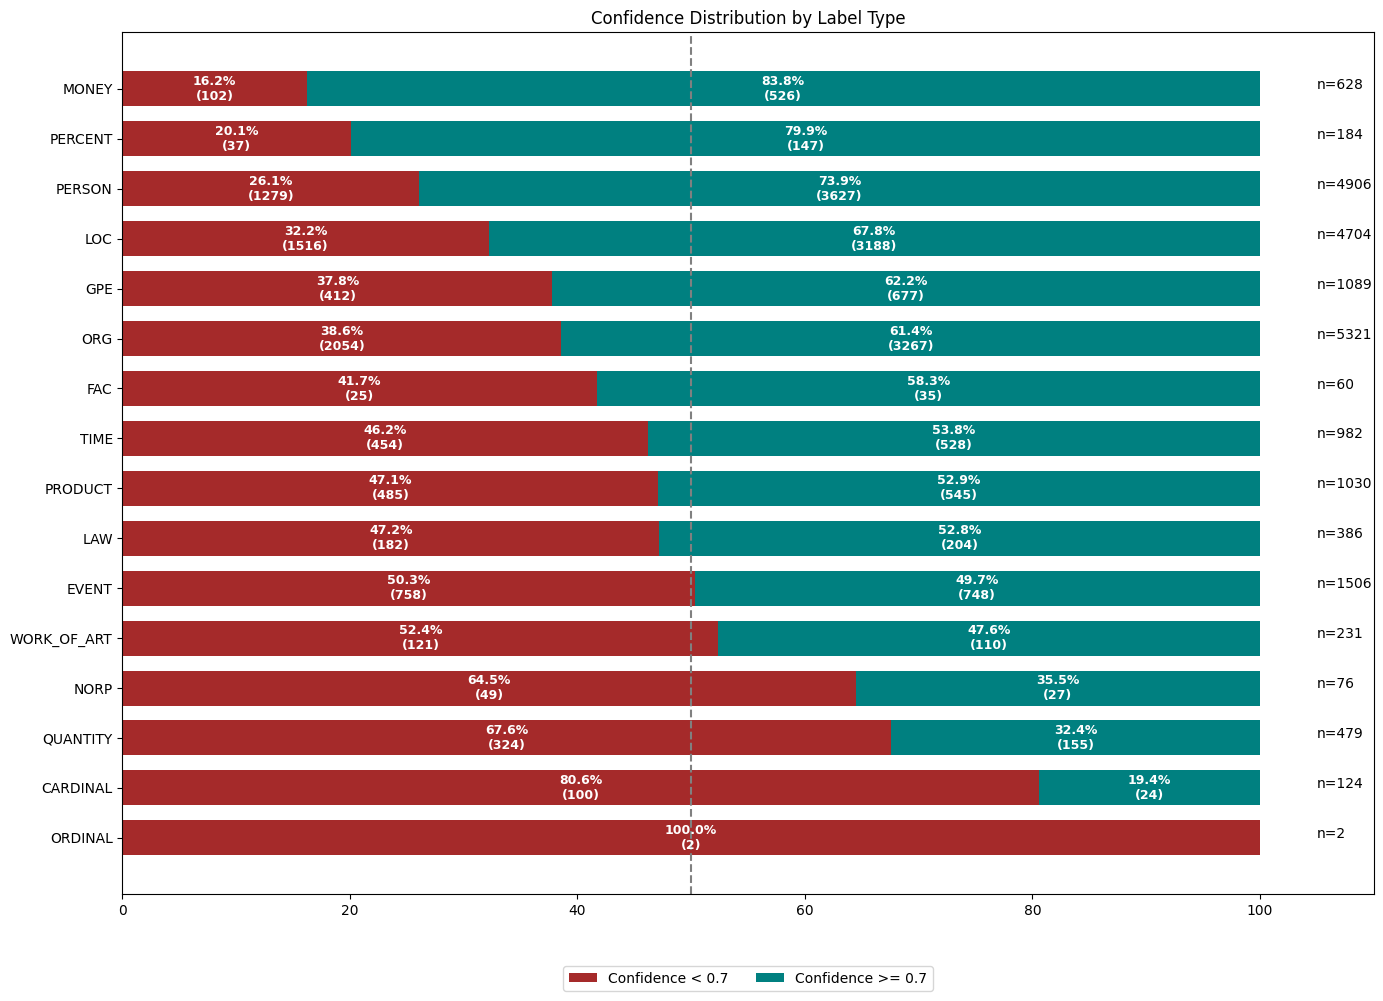

In [870]:
# visualize
plt.figure(figsize=(14, 10))
y_pos = np.arange(len(q3_conf))
bar_height = 0.7

# stacked horizontal bar charts
low_bars = plt.barh(y_pos, q3_conf['low_conf_pct'], 
                    height=bar_height, color='brown', label='Confidence < 0.7')
high_bars = plt.barh(y_pos, q3_conf['high_conf_pct'], 
                     left=q3_conf['low_conf_pct'], 
                     height=bar_height, color='teal', label='Confidence >= 0.7')

# annotations
for i, (low_pct, high_pct, total) in enumerate(zip(q3_conf['low_conf_pct'], 
                                                   q3_conf['high_conf_pct'], 
                                                   q3_conf['total'])):
    # low confidence scores
    if low_pct > 1:     # to ensure space
        plt.text(low_pct/2, i, 
                 f'{low_pct:.1f}%\n({int(q3_conf["low_conf"].iloc[i])})', 
                 ha='center', va='center', color='white', fontsize=9, fontweight='bold')
    
    # high confidence scores
    if high_pct > 1:    # to ensure space 
        plt.text(q3_conf['low_conf_pct'].iloc[i] + high_pct/2, i, 
                 f'{high_pct:.1f}%\n({int(q3_conf["high_conf"].iloc[i])})', 
                 ha='center', va='center', color='white', fontsize=9, fontweight='bold')
    
    # total
    plt.text(105, i, f'n={total}')

    # line at 50%

# plot
plt.axvline(x=50, color='grey', linestyle='--')
plt.gca().invert_yaxis()
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.12), ncol=2)
plt.yticks(y_pos, q3_conf['label'])
plt.title('Confidence Distribution by Label Type')
plt.xlim(0, 110)
plt.tight_layout()
plt.show()

There are a few key points that can be taken away from this chart, but to break it down further:

Based on >= 50% high confidence score coverage(10 labels):
* Even though 'MONEY','PERCENT', 'GPE', 'LAW', 'TIME', 'PRODUCT', and 'EVENT' are considered to be low-frequency labels, based on the EDA, they have high confidence score coverage.
* The high-frequency labels, 'ORG', 'PERSON', and 'LOC' all have high confidence score coverage.
* The 'PERCENT' may be an outlier, because despite having the lowest number of labels in this category, it is has the second highest high confidence score coverage. This might be because of the simplicity/less variability of the annotation i.e. the symbol '%' is used as the indication for the label.

Based on < 50% high confidence score coverage(6 labels):
* All of the labels in these category are the low-frequency labels based on the EDA.
* The ' QUANTITY' label may in an outlier, because despite having the highest number of labels, about double from the second highest, it is has a poor high confidence score coverage. This might be because of the variability of the annotation, from being numbers.

From this, a label-focused annotation can be done for the fine-tuning:
* 'ORDINAL', 'CARDINAL', 'QUANTITY', 'NORP', 'WORK_OF_ART', and 'EVENT' should be the labels of focus.

In [ ]:
# get low high confidence covergage labels with low confidence
low_high_cov_label = ['ORDINAL', 'CARDINAL', 'QUANTITY', 'NORP', 'WORK_OF_ART', 'EVENT']

ft_q3 = df[df['label'].isin(low_high_cov_label)]
ft_q3 = ft_q3[ft_q3['score'] < 0.7]
ft_q3.sort_values('score')

,start,end,text,label,score
17776,1154306,1154312,gambar,WORK_OF_ART,0.500136
4409,82087,82091,maut,EVENT,0.500217
4445,82577,82581,maut,EVENT,0.500217
14253,904389,904408,kejohanan sukan sea,EVENT,0.500327
10203,562954,562993,majlis memetrai memorandum persefahaman,EVENT,0.500333
...,...,...,...,...,...
13458,831306,831330,sukan olimpik paris 2024,EVENT,0.699123
7859,348538,348553,kebakaran hutan,EVENT,0.699162
11112,632664,632678,modus operandi,WORK_OF_ART,0.699344
7057,288327,288393,"haji.\n\ndalam pada itu, jurucakap komander ka...",EVENT,0.699439


-----------
### Q4: Is confidence score correlated with text length or complexity?
Find the correlation between length of texts and confidence scores.

#### Data Preparation

In [872]:
# overview
df.head()

,start,end,text,label,score
0,11,33,ashraf semakin misteri,PERSON,0.624216
1,36,51,utusan malaysia,ORG,0.669583
2,63,75,waris lelaki,PERSON,0.617030
3,96,111,utusan malaysia,ORG,0.778188
4,112,130,abang jo tak tamak,PERSON,0.896389


In [873]:
# get characters
q4_chara_analysis = txt_len.copy()
q4_chara_analysis

,start,end,text,label,score,chara
0,11,33,ashraf semakin misteri,PERSON,0.624216,22
1,36,51,utusan malaysia,ORG,0.669583,15
2,63,75,waris lelaki,PERSON,0.617030,12
3,96,111,utusan malaysia,ORG,0.778188,15
4,112,130,abang jo tak tamak,PERSON,0.896389,18
...,...,...,...,...,...,...
21703,1296557,1296571,berpuluh-puluh,QUANTITY,0.605398,14
21704,1296585,1296590,gempa,EVENT,0.639610,5
21705,1296615,1296621,bandar,LOC,0.572937,6
21706,1296631,1296639,istanbul,LOC,0.941040,8


#### Correlation Analysis
In this analysis, the tests that will be conducted are:
1. Pearson correlation - to determine the linear relationship
2. Spearman correlation - to determine the monotonic relationship

**Null hypothesis:**\
There is no correlation between text length and confidence scores.

**Alternative hypothesis:**\
There is a correlation between text length and confidence scores.

In [874]:
# pearson
q4_pearson_corr, q4_p_value = stats.pearsonr(
    q4_chara_analysis['chara'],
    q4_chara_analysis['score']
)

# spearman
q4_spearman_rho, q4_p_spearman = stats.spearmanr(
    q4_chara_analysis['chara'],
    q4_chara_analysis['score']
)

In [875]:
print(f"Spearman rho: {q4_spearman_rho:.3f}")
print(f"Spearman p: {q4_p_spearman:.4f}\n")
print(f"Pearson r: {q4_pearson_corr:.3f}")
print(f"Pearson p: {q4_p_value:.4f}\n")

Spearman rho: 0.103
Spearman p: 0.0000

Pearson r: 0.059
Pearson p: 0.0000



Based on these readings,

There is a highly significant (p < 0.05) weak positive monotonic and linear relationship (rho < 0.4, r < 0.4). This means that the effects of the text length to confidence score is negligible.

Therefore, we reject the null hypothesis. However, the relationship has no practical importance.

So, no fine-tuning can be uased by the text lengths.

-----------
### Q5: Is confidence score correlated with text complexity?
Find the correlation between the complexity of texts and confidence scores.

#### Data Preparation

In [876]:
df.head()

,start,end,text,label,score
0,11,33,ashraf semakin misteri,PERSON,0.624216
1,36,51,utusan malaysia,ORG,0.669583
2,63,75,waris lelaki,PERSON,0.617030
3,96,111,utusan malaysia,ORG,0.778188
4,112,130,abang jo tak tamak,PERSON,0.896389


In [877]:
q5_complex_analysis = df[['text', 'score']].copy()

In [878]:
q5_complex_analysis = q5_complex_analysis.assign(
    # word complexity
    word_count = q5_complex_analysis['text'].str.split().str.len(),
    unique_words = q5_complex_analysis['text'].apply(lambda x: len(set(x.split()))),
    lexical_diversity = lambda x: x['unique_words'] / x['word_count'],

    avg_word_length = q5_complex_analysis['text'].str.split().apply(
        lambda words: sum(len(w) for w in words) / len(words) if words else 0),
    
    # sentence complexity
    sentence_count = q5_complex_analysis['text'].apply(
        lambda x: len([s for s in x.split('.') if s.strip()])),

    avg_sentence_length = lambda x: x['word_count'] / x['sentence_count'],
    
    # Special character complexity
    special_char_count = q5_complex_analysis['text'].apply(lambda x: sum(1 for char in x if not char.isalnum() and not char.isspace())),

    special_char_ratio = lambda x: x['special_char_count'] / x['text'].str.len(),
        
    # Combined complexity score (simple average)
    complexity = lambda x: (
        x['lexical_diversity'] + 
        x['avg_word_length'] / 10 + 
        np.log1p(x['avg_sentence_length']) / 5 +  
        x['special_char_ratio']
    ) / 4
)

q5_complex_analysis[['text', 'score', 'complexity']].sort_values('complexity')

,text,score,complexity
17551,x,0.775882,0.309657
3642,4,0.502703,0.309657
3144,3,0.596241,0.309657
3140,2,0.510586,0.309657
2117,3,0.775583,0.309657
...,...,...,...
13074,malaysia-singapura,0.517257,0.748546
10653,kontraktor-kontraktor,0.637084,0.821562
10645,kontraktor-kontraktor,0.593937,0.821562
14775,pengkritik-pengkritik,0.622965,0.821562


In [880]:
# pearson
q5_pearson_corr, q5_p_value = stats.pearsonr(
    q5_complex_analysis['complexity'],
    q5_complex_analysis['score']
)

# spearman
q5_spearman_rho, q5_p_spearman = stats.spearmanr(
    q5_complex_analysis['complexity'],
    q5_complex_analysis['score']
)

In [881]:
print(f"Spearman rho: {q5_spearman_rho:.3f}")
print(f"Spearman p: {q5_p_spearman:.4f}\n")
print(f"Pearson r: {q5_pearson_corr:.3f}")
print(f"Pearson p: {q5_p_value:.4f}\n")

Spearman rho: 0.017
Spearman p: 0.0126

Pearson r: 0.025
Pearson p: 0.0002



---------
### Q6: Does context window size affect confidence?
Examine scores relative to entity position in sentence (beginning, middle, end).

---------
----------
## Fine-Tuning Preparation

--------
### Annotations
1. Get list of texts

In [ ]:
# low-frequency labels
q1_low_freq_full

,start,end,text,label,score
15,355,361,kerusi,PRODUCT,0.597386
23,526,531,punah,WORK_OF_ART,0.501662
54,1143,1148,video,WORK_OF_ART,0.577966
59,1247,1255,malaysia,GPE,0.551849
62,1321,1329,malaysia,GPE,0.571119
...,...,...,...,...,...
21690,1296218,1296228,bas kilang,PRODUCT,0.561457
21693,1296322,1296331,pagi tadi,TIME,0.594813
21694,1296339,1296347,kejadian,EVENT,0.610544
21703,1296557,1296571,berpuluh-puluh,QUANTITY,0.605398


In [ ]:
# low high-confidence score coverage labels
q3_low_high_cov

,start,end,text,label,score
23,526,531,punah,WORK_OF_ART,0.501662
54,1143,1148,video,WORK_OF_ART,0.577966
74,1531,1544,operasi kesan,EVENT,0.630561
90,1956,1965,kejuaraan,EVENT,0.646641
101,2161,2163,41,QUANTITY,0.692298
...,...,...,...,...,...
21665,1294500,1294515,kempen pramusim,EVENT,0.602576
21676,1295391,1295417,festival filem luar negara,EVENT,0.615164
21694,1296339,1296347,kejadian,EVENT,0.610544
21703,1296557,1296571,berpuluh-puluh,QUANTITY,0.605398
